## Maya HTT - Data Science Intro Exercise

How does data science work? Difficult to describe, but this notebook will work with some sample data as a gentle introduction to the process, and some of the Python libraries that are used.

In [1]:
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate

import matplotlib.pyplot as plt
%matplotlib inline

Load hourly electricity demand data from Hydro-Québec for 2019 and 2020.

In [2]:
hq_indata_2019 = pd.read_excel('./Data/HydroQuebec/2019-demande-electricite-quebec.xlsx')
hq_indata_2019['DateString'] = hq_indata_2019['Date'].astype(str).str[:-3]

hq_indata_2020 = pd.read_excel('./Data/HydroQuebec/2020-demande-electricite-quebec.xlsx')
hq_indata_2020['DateString'] = hq_indata_2020['Date'].astype(str).str[:-3]

Plot and inspect the Hydro-Quebec data

In [3]:
hq_indata_2019.head()

,Date,Moyenne (MW),DateString
0,2019-01-01 01:00:00,23762.55,2019-01-01 01:00
1,2019-01-01 02:00:00,23830.23,2019-01-01 02:00
2,2019-01-01 03:00:00,23608.07,2019-01-01 03:00
3,2019-01-01 04:00:00,23562.48,2019-01-01 04:00
4,2019-01-01 05:00:00,23546.16,2019-01-01 05:00


Text(0.5, 1.0, 'Hydro-Quebec Demand (2020)')

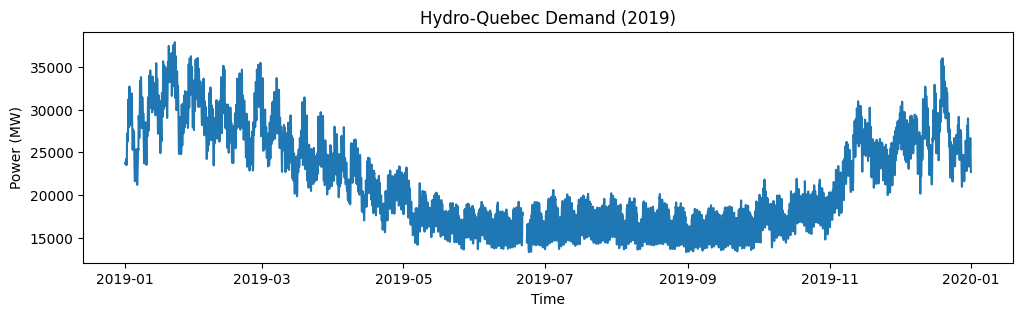

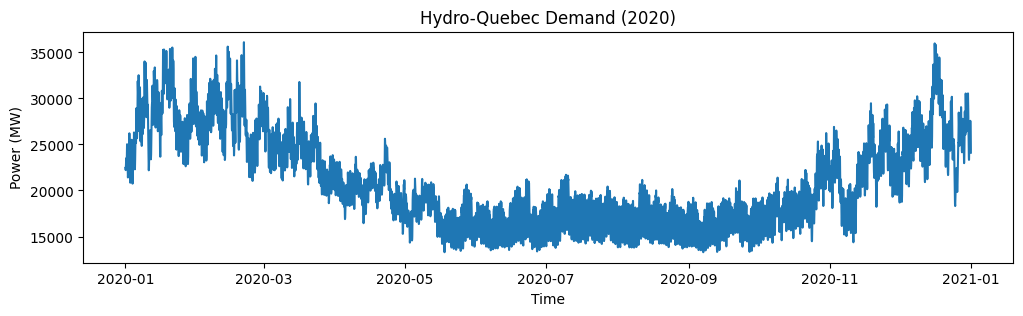

In [4]:
plt.figure(figsize=[12,3])
plt.plot(hq_indata_2019.iloc[:,0], hq_indata_2019.iloc[:,1])
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.title('Hydro-Quebec Demand (2019)')

plt.figure(figsize=[12,3])
plt.plot(hq_indata_2020.iloc[:,0], hq_indata_2020.iloc[:,1])
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.title('Hydro-Quebec Demand (2020)')

Load and concatenate Envrionment Canada hourly weather observations (at Dorval airport) for 2019 and 2020.

Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'Date/Time (LST)', 'Year', 'Month', 'Day', 'Time (LST)', 'Flag',
       'Temp (°C)', 'Temp Flag', 'Dew Point Temp (°C)', 'Dew Point Temp Flag',
       'Rel Hum (%)', 'Rel Hum Flag', 'Precip. Amount (mm)',
       'Precip. Amount Flag', 'Wind Dir (10s deg)', 'Wind Dir Flag',
       'Wind Spd (km/h)', 'Wind Spd Flag', 'Visibility (km)',
       'Visibility Flag', 'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx',
       'Hmdx Flag', 'Wind Chill', 'Wind Chill Flag', 'Weather'],
      dtype='object')


Text(0.5, 1.0, 'Environment Canada - Dorval (2020)')

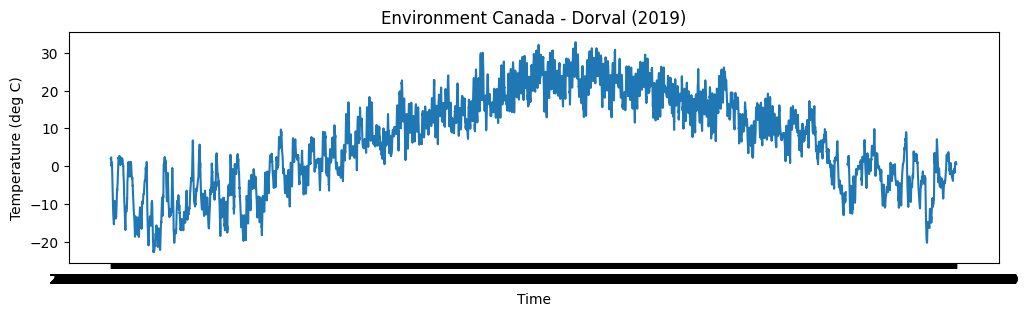

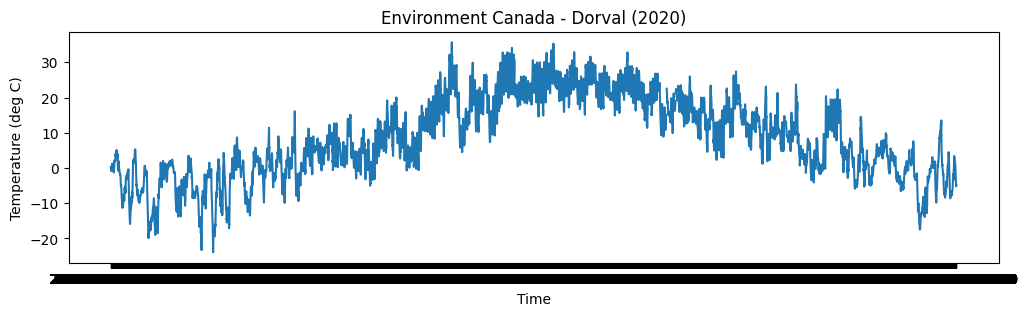

In [5]:
ec_dorval_2019 = pd.DataFrame()
for n in range(1,13):
    data_tmp = pd.read_csv(f'./Data/EnvironmentCanada/2019/en_climate_hourly_QC_702S006_' + "{:02d}".format(n) + '-2019_P1H.csv')
    ec_dorval_2019 = pd.concat([ec_dorval_2019, data_tmp])

# ec_dorval_2019['Timestamp'] = pd.to_datetime(ec_dorval_2019.iloc[:,4])

ec_dorval_2020 = pd.DataFrame()
for n in range(1,13):
    data_tmp = pd.read_csv(f'./Data/EnvironmentCanada/2020/en_climate_hourly_QC_702S006_' + "{:02d}".format(n) + '-2020_P1H.csv')
    ec_dorval_2020 = pd.concat([ec_dorval_2020, data_tmp])

# ec_dorval_2020['Timestamp'] = pd.to_datetime(ec_dorval_2020.iloc[:,4])

print(ec_dorval_2019.columns)

# ec_dorval_2019.head()

plt.figure(figsize=[12,3])
plt.plot(ec_dorval_2019.iloc[:,4], ec_dorval_2019.iloc[:,10])
plt.xlabel('Time')
plt.ylabel('Temperature (deg C)')
plt.title('Environment Canada - Dorval (2019)')

plt.figure(figsize=[12,3])
plt.plot(ec_dorval_2020.iloc[:,4], ec_dorval_2020.iloc[:,10])
plt.xlabel('Time')
plt.ylabel('Temperature (deg C)')
plt.title('Environment Canada - Dorval (2020)')


Join Hydro Quebec demand data and Environment Canada (Dorval) information, then select most relevant columns.

In [6]:
alldata_2019 = hq_indata_2019.merge(ec_dorval_2019, left_on='DateString', right_on='Date/Time (LST)')
alldata_2019 = alldata_2019[['Date/Time (LST)','Year', 'Month','Day','Time (LST)','Moyenne (MW)','Temp (°C)','Dew Point Temp (°C)','Wind Dir (10s deg)','Wind Spd (km/h)']]
alldata_2019 = alldata_2019.sample(frac=1).reset_index(drop=True)
# alldata_2019.head()

alldata_2020 = hq_indata_2020.merge(ec_dorval_2020, left_on='DateString', right_on='Date/Time (LST)')
alldata_2020 = alldata_2020[['Date/Time (LST)','Year', 'Month','Day','Time (LST)','Moyenne (MW)','Temp (°C)','Dew Point Temp (°C)','Wind Dir (10s deg)','Wind Spd (km/h)']]
alldata_2020 = alldata_2020.sample(frac=1).reset_index(drop=True)
alldata_2020.head()

,Date/Time (LST),Year,Month,Day,Time (LST),Moyenne (MW),Temp (°C),Dew Point Temp (°C),Wind Dir (10s deg),Wind Spd (km/h)
0,2020-07-18 11:00,2020,7,18,11:00,18326.43,28.1,20.0,20.0,15.0
1,2020-06-11 20:00,2020,6,11,20:00,18166.83,20.8,11.0,23.0,24.0
2,2020-07-14 13:00,2020,7,14,13:00,18683.54,23.0,14.4,3.0,21.0
3,2020-04-24 13:00,2020,4,24,13:00,21021.70,9.6,-13.8,1.0,17.0
4,2020-03-29 07:00,2020,3,29,07:00,20330.89,4.9,-3.5,3.0,13.0


Check some correlations for 2019 data. Think about the results. Is there a reasonable explanation for the significant correlations? What might be the cause of the relationships? Check out the strongest correlations with scatter plots of 2019 data.

In [7]:
alldata_2019[['Month','Day','Moyenne (MW)','Temp (°C)','Dew Point Temp (°C)','Wind Dir (10s deg)','Wind Spd (km/h)']].corr()

,Month,Day,Moyenne (MW),Temp (°C),Dew Point Temp (°C),Wind Dir (10s deg),Wind Spd (km/h)
Month,1.000000,0.011299,-0.345904,0.299689,0.345390,-0.063691,-0.102195
Day,0.011299,1.000000,-0.019150,0.041095,0.064654,0.006632,-0.030384
Moyenne (MW),-0.345904,-0.019150,1.000000,-0.858960,-0.856867,0.023345,0.171635
Temp (°C),0.299689,0.041095,-0.858960,1.000000,0.938173,0.009744,-0.078086
Dew Point Temp (°C),0.345390,0.064654,-0.856867,0.938173,1.000000,-0.011156,-0.127366
Wind Dir (10s deg),-0.063691,0.006632,0.023345,0.009744,-0.011156,1.000000,0.029439
Wind Spd (km/h),-0.102195,-0.030384,0.171635,-0.078086,-0.127366,0.029439,1.000000


Text(0.5, 1.0, 'Wind Spd (km/h)')

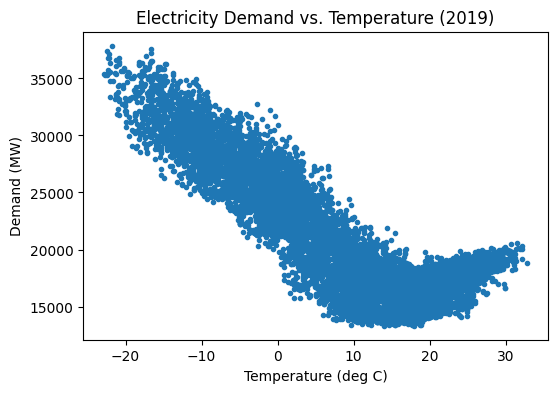

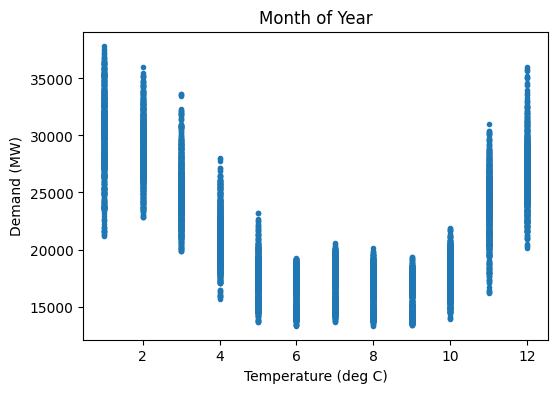

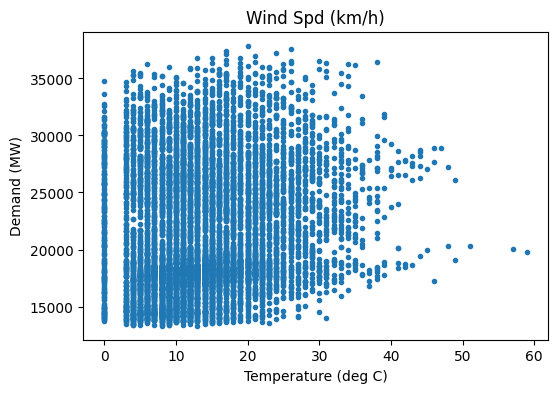

In [8]:
plt.figure(figsize=[6,4])
plt.plot(alldata_2019.loc[:,'Temp (°C)'], alldata_2019.loc[:,'Moyenne (MW)'], '.')
plt.xlabel('Temperature (deg C)')
plt.ylabel('Demand (MW)')
plt.title('Electricity Demand vs. Temperature (2019)')

plt.figure(figsize=[6,4])
plt.plot(alldata_2019.loc[:,'Month'], alldata_2019.loc[:,'Moyenne (MW)'], '.')
plt.xlabel('Temperature (deg C)')
plt.ylabel('Demand (MW)')
plt.title('Month of Year')

plt.figure(figsize=[6,4])
plt.plot(alldata_2019.loc[:,'Wind Spd (km/h)'], alldata_2019.loc[:,'Moyenne (MW)'], '.')
plt.xlabel('Temperature (deg C)')
plt.ylabel('Demand (MW)')
plt.title('Wind Spd (km/h)')

#### Linear Regression: Starting simple

Linear regression of demand with temperature, including a cross-validation.

Linear regression model coefficients:  [-369.15599119 -158.2005773 ]
Linear regression model R2 (part of variance explained):  0.746933266926302
Linear regression model root mean squared error:  2742.2476199921693
Avg Train R2 : 0.7469453812288318 	 Avg Test R2 0.7466570502366531


Text(0.5, 1.0, 'Linear Regression Model of Demand')

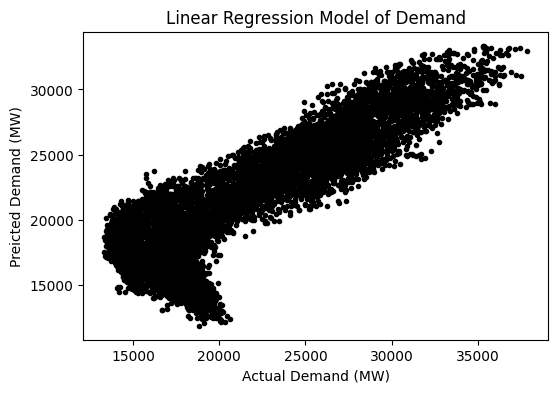

In [9]:
# Prepare temperature, month, and demand data from 2019: temperature and month as inputs (X), demand as target (y)
X = alldata_2019[['Temp (°C)','Month']]
y = alldata_2019.loc[:,'Moyenne (MW)']

# Remove cases with missing data
X = X[(~X['Temp (°C)'].isna()) & (~X['Month'].isna()) & (~y.isna())]
y = y[(~X['Temp (°C)'].isna()) & (~X['Month'].isna()) & (~y.isna())]

# K-fold split for cross-validation
# kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create a linear regression model, ready for use. Model comes from scikit-learn (sklearn) library, see 'includes' at start of the notebook.
lr_model = LinearRegression()

lr_model.fit(X, y)
y_predict_lr = lr_model.predict(X)

print('Linear regression model coefficients: ', lr_model.coef_)
print('Linear regression model R2 (part of variance explained): ', r2_score(y, y_predict_lr))
print('Linear regression model root mean squared error: ', root_mean_squared_error(y, y_predict_lr))

cv_scores = cross_validate(lr_model, X, y, scoring=('r2'), return_train_score=True, cv=5)
print('Avg Train R2 :', np.mean(cv_scores['train_score']),'\t', 'Avg Test R2', np.mean(cv_scores['test_score']))

plt.figure(figsize=[6,4])
plt.plot(y, y_predict_lr, 'k.')
plt.xlabel('Actual Demand (MW)')
plt.ylabel('Preicted Demand (MW)')
plt.title('Linear Regression Model of Demand')


As indicated by correlation, there is a definite relationship between electricity demand and temperature, but the linear regression model is not great. On the bright side, the R2 for training is only slightly higher than the R2 for validation, suggesting no overfitting.

Let's add some of the other variables as additional inputs to the linear regression, it's worth a try! Actually, it is not much better.

In [11]:
X2 = alldata_2019[['Month','Day','Temp (°C)','Dew Point Temp (°C)','Wind Dir (10s deg)','Wind Spd (km/h)']]
y2 = alldata_2019.loc[:,'Moyenne (MW)']

# Remove cases with missing data
X2 = X2[(~X2['Month'].isna()) & (~X2['Day'].isna()) & (~X2['Temp (°C)'].isna()) & (~X2['Dew Point Temp (°C)'].isna()) & (~X2['Wind Dir (10s deg)'].isna()) & (~X2['Wind Spd (km/h)'].isna()) & (~y2.isna())]
y2 = y2[(~X2['Month'].isna()) & (~X2['Day'].isna()) & (~X2['Temp (°C)'].isna()) & (~X2['Dew Point Temp (°C)'].isna()) & (~X2['Wind Dir (10s deg)'].isna()) & (~X2['Wind Spd (km/h)'].isna()) & (~y2.isna())]

# Create a linear regression model, ready for use. Model comes from scikit-learn (sklearn) library, see 'includes' at start of the notebook.
lr2_model = LinearRegression()

lr2_model.fit(X2, y2)
y2_predict_lr2 = lr2_model.predict(X2)

print('Linear regression model 2 coefficients: ', lr2_model.coef_)
print('Linear regression model 2 R2 (part of variance explained): ', r2_score(y2, y2_predict_lr2))
print('Linear regression model 2 root mean squared error: ', root_mean_squared_error(y2, y2_predict_lr2))

cv2_scores = cross_validate(lr2_model, X2, y2, scoring=('r2'), return_train_score=True, cv=5)
print('Avg Train R2 :', np.mean(cv2_scores['train_score']),'\t', 'Avg Validation R2', np.mean(cv2_scores['test_score']))

# plt.figure(figsize=[6,4])
# plt.plot(y2, y2_predict_lr2, 'k.')
# plt.xlabel('Actual Demand (MW)')
# plt.ylabel('Preicted Demand (MW)')
# plt.title('Linear Regression Model of Demand')


Linear regression model 2 coefficients:  [-102.76438548   17.20464128 -218.76817709 -171.6315811     7.28337789
   54.91454534]
Linear regression model 2 R2 (part of variance explained):  0.7694925099044976
Linear regression model 2 root mean squared error:  2611.9715283269074
Avg Train R2 : 0.7695375691668145 	 Avg Validation R2 0.7688849399959364


#### Lasso Regression: Add regularization to reduce collinearity problems

Lasso is a modified version of linear regression, with a 'regularization' term that tries to 'shrink' model coefficients without significant loss of model accuracy. Some or our inputs (such as 'Day') have low correlation with electricity demand, but significant coefficients in the linear regression model. 

In [12]:
X2 = alldata_2019[['Month','Day','Temp (°C)','Dew Point Temp (°C)','Wind Dir (10s deg)','Wind Spd (km/h)']]
y2 = alldata_2019.loc[:,'Moyenne (MW)']

# Remove cases with missing data
X2 = X2[(~X2['Month'].isna()) & (~X2['Day'].isna()) & (~X2['Temp (°C)'].isna()) & (~X2['Dew Point Temp (°C)'].isna()) & (~X2['Wind Dir (10s deg)'].isna()) & (~X2['Wind Spd (km/h)'].isna()) & (~y2.isna())]
y2 = y2[(~X2['Month'].isna()) & (~X2['Day'].isna()) & (~X2['Temp (°C)'].isna()) & (~X2['Dew Point Temp (°C)'].isna()) & (~X2['Wind Dir (10s deg)'].isna()) & (~X2['Wind Spd (km/h)'].isna()) & (~y2.isna())]

# Create a ridge regression model, ready for use. Model comes from scikit-learn (sklearn) library, see 'includes' at start of the notebook.
lasso_model = Lasso(alpha=2000.0)

lasso_model.fit(X2, y2)
y2_predict_lasso = lasso_model.predict(X2)

print('Lasso regression model coefficients: ', lasso_model.coef_)
print('Lasso regression model R2 (part of variance explained): ', r2_score(y2, y2_predict_lasso))
print('Lasso regression model root mean squared error: ', root_mean_squared_error(y2, y2_predict_lasso))

cv_lasso_scores = cross_validate(lasso_model, X2, y2, scoring=('r2'), return_train_score=True, cv=5)
print('Avg Train R2 :', np.mean(cv_lasso_scores['train_score']),'\t', 'Avg Validation R2', np.mean(cv_lasso_scores['test_score']))



Lasso regression model coefficients:  [  -0.            0.         -208.8084442  -179.31190368    0.
   24.41971891]
Lasso regression model R2 (part of variance explained):  0.7616450159502057
Lasso regression model root mean squared error:  2656.0609479041027
Avg Train R2 : 0.7616748179918397 	 Avg Validation R2 0.7611824855253302


The model is still weak, we must be missing something! Let's add variables for time of day, and day of week.

In [13]:
alldata_2019['HourOfDay']    = alldata_2019['Time (LST)'].str.slice(start=0, stop=2).astype(int)
alldata_2019['DayNightFlag'] = ((alldata_2019['HourOfDay'] > 6) & (alldata_2019['HourOfDay'] <= 18)) * 1
# alldata_2019.head(8)

alldata_2020['HourOfDay']    = alldata_2020['Time (LST)'].str.slice(start=0, stop=2).astype(int)
alldata_2020['DayNightFlag'] = ((alldata_2020['HourOfDay'] > 6) & (alldata_2020['HourOfDay'] <= 18)) * 1
alldata_2020.head(8)


,Date/Time (LST),Year,Month,Day,Time (LST),Moyenne (MW),Temp (°C),Dew Point Temp (°C),Wind Dir (10s deg),Wind Spd (km/h),HourOfDay,DayNightFlag
0,2020-07-18 11:00,2020,7,18,11:00,18326.43,28.1,20.0,20.0,15.0,11,1
1,2020-06-11 20:00,2020,6,11,20:00,18166.83,20.8,11.0,23.0,24.0,20,0
2,2020-07-14 13:00,2020,7,14,13:00,18683.54,23.0,14.4,3.0,21.0,13,1
3,2020-04-24 13:00,2020,4,24,13:00,21021.70,9.6,-13.8,1.0,17.0,13,1
4,2020-03-29 07:00,2020,3,29,07:00,20330.89,4.9,-3.5,3.0,13.0,7,1
5,2020-09-15 18:00,2020,9,15,18:00,18944.96,12.3,6.3,30.0,5.0,18,1
6,2020-08-09 09:00,2020,8,9,09:00,15669.97,23.6,19.0,22.0,11.0,9,1
7,2020-01-04 12:00,2020,1,4,12:00,24551.08,1.5,-3.3,5.0,14.0,12,1


In [14]:
alldata_2019['DayOfWeek']    = pd.to_datetime(alldata_2019['Date/Time (LST)']).dt.dayofweek
alldata_2019['WeekendFlag'] = (alldata_2019['DayOfWeek'] >= 5) * 1
# alldata_2019.head(145)

alldata_2020['DayOfWeek']    = pd.to_datetime(alldata_2020['Date/Time (LST)']).dt.dayofweek
alldata_2020['WeekendFlag'] = (alldata_2020['DayOfWeek'] >= 5) * 1
# alldata_2020.head()

alldata_2019[['Month','Day','Moyenne (MW)','Temp (°C)','Dew Point Temp (°C)','Wind Dir (10s deg)','Wind Spd (km/h)','DayNightFlag','WeekendFlag']].corr()


,Month,Day,Moyenne (MW),Temp (°C),Dew Point Temp (°C),Wind Dir (10s deg),Wind Spd (km/h),DayNightFlag,WeekendFlag
Month,1.000000,0.011299,-0.345904,0.299689,0.345390,-0.063691,-0.102195,-0.000448,0.006102
Day,0.011299,1.000000,-0.019150,0.041095,0.064654,0.006632,-0.030384,-0.000100,0.002539
Moyenne (MW),-0.345904,-0.019150,1.000000,-0.858960,-0.856867,0.023345,0.171635,0.129168,-0.061571
Temp (°C),0.299689,0.041095,-0.858960,1.000000,0.938173,0.009744,-0.078086,0.103285,-0.003999
Dew Point Temp (°C),0.345390,0.064654,-0.856867,0.938173,1.000000,-0.011156,-0.127366,0.004981,0.000972
Wind Dir (10s deg),-0.063691,0.006632,0.023345,0.009744,-0.011156,1.000000,0.029439,0.029775,0.020109
Wind Spd (km/h),-0.102195,-0.030384,0.171635,-0.078086,-0.127366,0.029439,1.000000,0.196392,-0.030435
DayNightFlag,-0.000448,-0.000100,0.129168,0.103285,0.004981,0.029775,0.196392,1.000000,-0.000072
WeekendFlag,0.006102,0.002539,-0.061571,-0.003999,0.000972,0.020109,-0.030435,-0.000072,1.000000


Try Lasso regression with the added flags for night vs. day, weekend vs. weekday. No impact in this model. Lasso still collapsing all but temperature, dew point temperature and wind speed coefficients.

In [15]:
X3 = alldata_2019[['Month','Day','Temp (°C)','Dew Point Temp (°C)','Wind Dir (10s deg)','Wind Spd (km/h)', 'DayNightFlag', 'WeekendFlag']]
y3 = alldata_2019.loc[:,'Moyenne (MW)']

# Remove cases with missing data
X3 = X3[(~X3['Month'].isna()) & (~X3['Day'].isna()) & (~X3['Temp (°C)'].isna()) & (~X3['Dew Point Temp (°C)'].isna()) & (~X3['Wind Dir (10s deg)'].isna()) & (~X3['Wind Spd (km/h)'].isna()) & (~y3.isna())]
y3 = y3[(~X3['Month'].isna()) & (~X3['Day'].isna()) & (~X3['Temp (°C)'].isna()) & (~X3['Dew Point Temp (°C)'].isna()) & (~X3['Wind Dir (10s deg)'].isna()) & (~X3['Wind Spd (km/h)'].isna()) & (~y3.isna())]

# Create a ridge regression model, ready for use. Model comes from scikit-learn (sklearn) library, see 'includes' at start of the notebook.
lasso_model_extra = Lasso(alpha=2000.0)

lasso_model_extra.fit(X3, y3)
y3_predict_lasso_extra = lasso_model_extra.predict(X3)

print('Lasso regression model coefficients: ', lasso_model_extra.coef_)
print('Lasso regression model R2 (part of variance explained): ', r2_score(y3, y3_predict_lasso_extra))
print('Lasso regression model root mean squared error: ', root_mean_squared_error(y3, y3_predict_lasso_extra))

cv_lasso_extra_scores = cross_validate(lasso_model_extra, X3, y3, scoring=('r2'), return_train_score=True, cv=5)
print('Avg Train R2 :', np.mean(cv_lasso_extra_scores['train_score']),'\t', 'Avg Validation R2', np.mean(cv_lasso_extra_scores['test_score']))



Lasso regression model coefficients:  [  -0.            0.         -208.8084442  -179.31190368    0.
   24.41971891    0.           -0.        ]
Lasso regression model R2 (part of variance explained):  0.7616450159502057
Lasso regression model root mean squared error:  2656.0609479041027
Avg Train R2 : 0.7616748179918397 	 Avg Validation R2 0.7611824855253302


#### Random Forest: We need a better model!

The relationship has nonlinearities. First, try a random forest regression model (ensemble version of decision tree) with the same set of inputs. Already very good!

In [23]:
X3 = alldata_2019[['Month','Day','Temp (°C)','Dew Point Temp (°C)','Wind Dir (10s deg)','Wind Spd (km/h)', 'DayNightFlag', 'WeekendFlag']]
y3 = alldata_2019.loc[:,'Moyenne (MW)']

# Remove cases with missing data
X3 = X3[(~X3['Month'].isna()) & (~X3['Day'].isna()) & (~X3['Temp (°C)'].isna()) & (~X3['Dew Point Temp (°C)'].isna()) & (~X3['Wind Dir (10s deg)'].isna()) & (~X3['Wind Spd (km/h)'].isna()) & (~y3.isna())]
y3 = y3[(~X3['Month'].isna()) & (~X3['Day'].isna()) & (~X3['Temp (°C)'].isna()) & (~X3['Dew Point Temp (°C)'].isna()) & (~X3['Wind Dir (10s deg)'].isna()) & (~X3['Wind Spd (km/h)'].isna()) & (~y3.isna())]

rf_model = RandomForestRegressor()
rf_model.fit(X3, y3)
y3_predict_rf = rf_model.predict(X3)
print(rf_model.get_params())

print('Random forest regression model R2 (part of variance explained): ', r2_score(y3, y3_predict_rf))
print('Random forest regression model root mean squared error: ', root_mean_squared_error(y3, y3_predict_rf))

cv_rf_scores = cross_validate(rf_model, X3, y3, scoring=('r2'), return_train_score=True, cv=5)
print('Avg Train R2 :', np.mean(cv_rf_scores['train_score']),'\t', 'Avg Validation R2', np.mean(cv_rf_scores['test_score']))

# plt.figure(figsize=[6,4])
# plt.plot(y3, y3_predict_rf, 'k.')
# plt.xlabel('Actual Demand (MW)')
# plt.ylabel('Preicted Demand (MW)')
# plt.title('Random Forest Model of Demand')


{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Random forest regression model R2 (part of variance explained):  0.9954785174542126
Random forest regression model root mean squared error:  365.81907479304294
Avg Train R2 : 0.9947501875031918 	 Avg Validation R2 0.9628049775598022


Let's provide the full detail of hour of day, and day of week, instead of the day/night and weekend/weekday flages.

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
[15793.905  23573.1534 18884.6354 ... 26425.8073 34244.1606 26114.9678]
Random forest regression model R2 (part of variance explained):  0.9981865362672119
Random forest regression model root mean squared error:  231.67563122696112
Avg Train R2 : 0.9978620889728035 	 Avg Validation R2 0.9847527757743209


Text(0.5, 1.0, 'Random Forest Model of Demand')

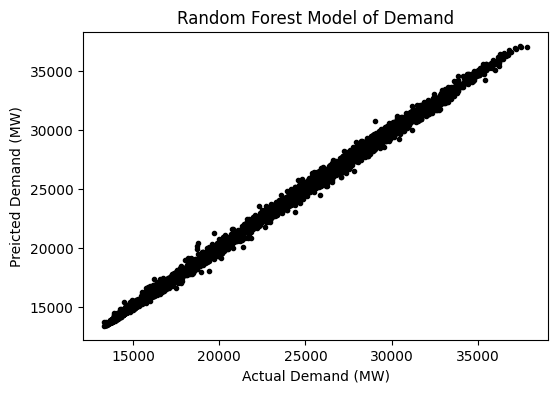

In [24]:
X4 = alldata_2019[['Month','Day','Temp (°C)','Dew Point Temp (°C)','Wind Dir (10s deg)','Wind Spd (km/h)', 'HourOfDay', 'DayOfWeek']]
y4 = alldata_2019.loc[:,'Moyenne (MW)']

# Remove cases with missing data
X4 = X4[(~X4['Month'].isna()) & (~X4['Day'].isna()) & (~X4['Temp (°C)'].isna()) & (~X4['Dew Point Temp (°C)'].isna()) & (~X4['Wind Dir (10s deg)'].isna()) & (~X4['Wind Spd (km/h)'].isna()) & (~y4.isna())]
y4 = y4[(~X4['Month'].isna()) & (~X4['Day'].isna()) & (~X4['Temp (°C)'].isna()) & (~X4['Dew Point Temp (°C)'].isna()) & (~X4['Wind Dir (10s deg)'].isna()) & (~X4['Wind Spd (km/h)'].isna()) & (~y4.isna())]

rf_model4 = RandomForestRegressor()
rf_model4.fit(X4, y4)
y4_predict_rf = rf_model4.predict(X4)
print(rf_model4.get_params())

print(y4_predict_rf)

print('Random forest regression model R2 (part of variance explained): ', r2_score(y4, y4_predict_rf))
print('Random forest regression model root mean squared error: ', root_mean_squared_error(y4, y4_predict_rf))

cv_rf4_scores = cross_validate(rf_model4, X4, y4, scoring=('r2'), return_train_score=True, cv=5)
print('Avg Train R2 :', np.mean(cv_rf4_scores['train_score']),'\t', 'Avg Validation R2', np.mean(cv_rf4_scores['test_score']))

plt.figure(figsize=[6,4])
plt.plot(y4, y4_predict_rf, 'k.')
plt.xlabel('Actual Demand (MW)')
plt.ylabel('Preicted Demand (MW)')
plt.title('Random Forest Model of Demand')


Those results look amazing! There are still a number of Random Forest model parameters you can play with, if you wish, but the results already seem to good to be true ...

Oh yeah. We still need to test the trained model on data it has never seen during either training or verification. Fortunately, we set aside the 2020 data as our test set. Now we make and check predictions using the model (trained and validated using 2019 data) applied to the 2020 data.

Not quite as good, but still reasonable. Especially considering everything that changed in 2020 with the start of the pandemic.

Random forest regression model R2 (part of variance explained):  0.943508226430775
Random forest regression model root mean squared error:  1154.2048182697758


Text(0.5, 1.0, 'Random Forest Model of Demand')

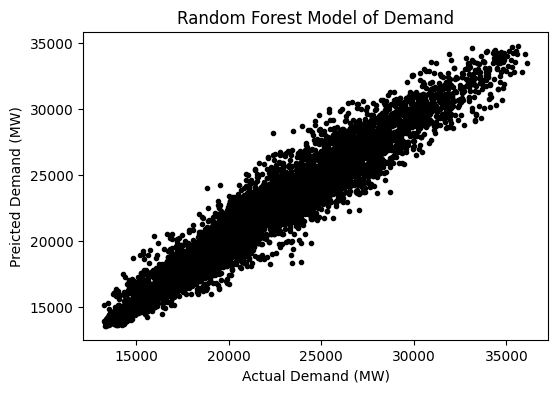

In [26]:
X4 = alldata_2020[['Month','Day','Temp (°C)','Dew Point Temp (°C)','Wind Dir (10s deg)','Wind Spd (km/h)', 'HourOfDay', 'DayOfWeek']]
y4 = alldata_2020.loc[:,'Moyenne (MW)']

# Remove cases with missing data
X4 = X4[(~X4['Month'].isna()) & (~X4['Day'].isna()) & (~X4['Temp (°C)'].isna()) & (~X4['Dew Point Temp (°C)'].isna()) & (~X4['Wind Dir (10s deg)'].isna()) & (~X4['Wind Spd (km/h)'].isna()) & (~y4.isna())]
y4 = y4[(~X4['Month'].isna()) & (~X4['Day'].isna()) & (~X4['Temp (°C)'].isna()) & (~X4['Dew Point Temp (°C)'].isna()) & (~X4['Wind Dir (10s deg)'].isna()) & (~X4['Wind Spd (km/h)'].isna()) & (~y4.isna())]

y4_predict_rf = rf_model4.predict(X4)

print('Random forest regression model R2 (part of variance explained): ', r2_score(y4, y4_predict_rf))
print('Random forest regression model root mean squared error: ', root_mean_squared_error(y4, y4_predict_rf))

plt.figure(figsize=[6,4])
plt.plot(y4, y4_predict_rf, 'k.')
plt.xlabel('Actual Demand (MW)')
plt.ylabel('Preicted Demand (MW)')
plt.title('Random Forest Model of Demand')


The scikit-learn libraries can also be used to implement basic neural networks. More 'industrial-scale' libraries such as Tensorflow and PyTorch can handle more demanding neural networks.